# Jupyter notebook to plot the saved results

## Importing required header files

In [32]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../../../FinRL/')
sys.path.append("../FinRL-Library")

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint
import itertools
import warnings
warnings.filterwarnings("ignore")


## Plotting individual results

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2021-04-06
End date,2022-04-01
Total months,12
,Backtest
Annual return,-7.7%
Cumulative returns,-7.7%
Annual volatility,15.0%
Sharpe ratio,-0.46
Calmar ratio,-0.43
Stability,0.20
Max drawdown,-18.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.99,2021-11-08,2022-03-08,NaT,NaN
1,4.94,2021-09-02,2021-09-30,2021-10-20,35
2,4.51,2021-06-04,2021-06-18,2021-08-12,50
3,3.62,2021-04-16,2021-05-12,2021-05-28,31
4,1.53,2021-08-16,2021-08-19,2021-08-25,8


Stress Events,mean,min,max
New Normal,-0.03%,-2.78%,2.42%


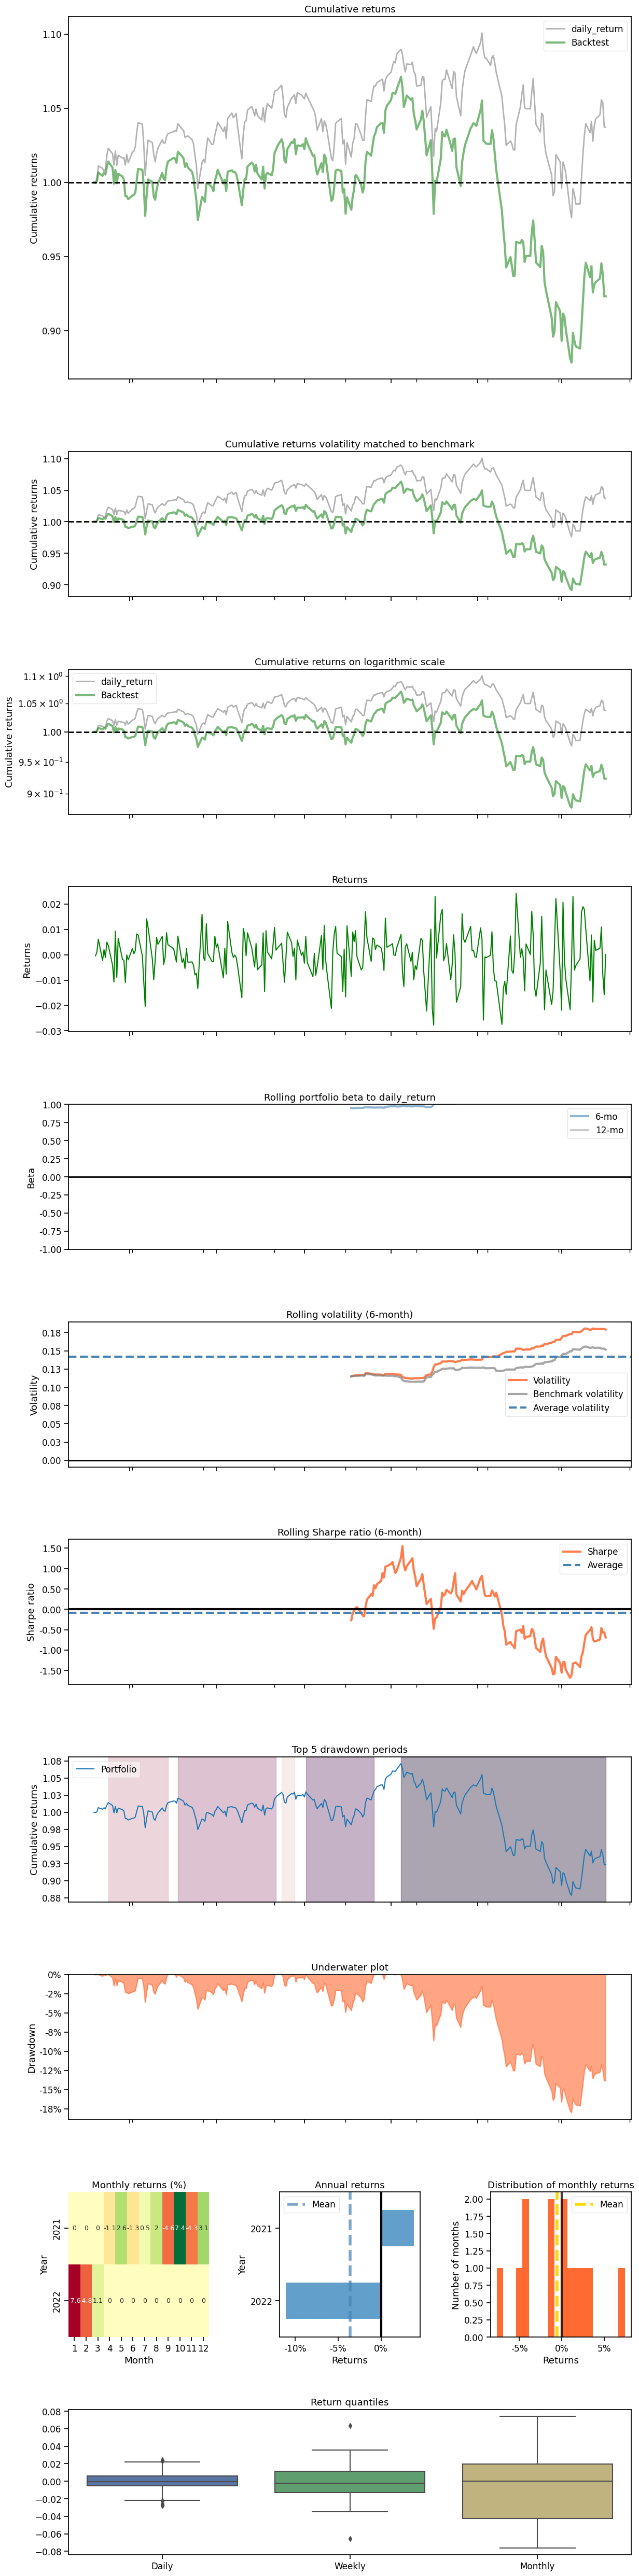

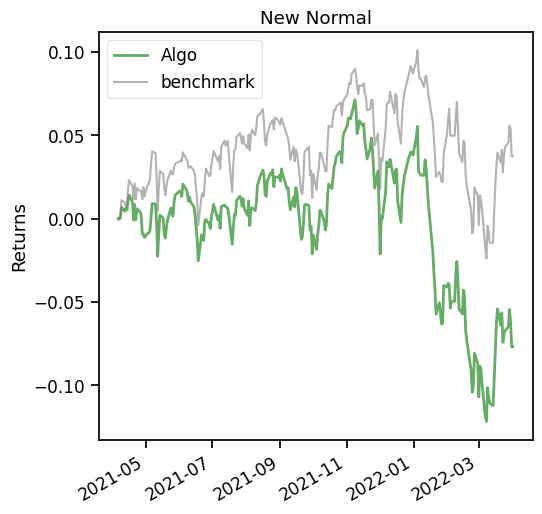

In [33]:
seed = 0
window_size = 63
retrain_window = 63
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'
use_extra_features = True
reward_type = "Sortino"
result_path = 'results/using_delta_1'
file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,retrain_window,use_extra_features, seed)
file = pd.read_csv(file_name)
df_account_value = file.copy()


%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [34]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Backtest Results===========
Annual return         -0.076729
Cumulative returns    -0.076729
Annual volatility      0.150264
Sharpe ratio          -0.458340
Calmar ratio          -0.426424
Stability              0.200145
Max drawdown          -0.179937
Omega ratio            0.926190
Sortino ratio         -0.615567
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.893083
Daily value at risk   -0.019205
dtype: float64
==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970

## Plotting multiple seeds

In [35]:
seeds = [0,1,2,3,4]
window_size = 63
# retrain_window = 21
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'
use_extra_features = True
reward_type = "Sharpe"
result_path = 'results/using_delta_1'
dfs = []
for seed in seeds:
    file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,window_size,use_extra_features, seed)
    file = pd.read_csv(file_name)
    dfs.append(file.copy())

# df_account_value = file.copy()


In [36]:

window = 5
dates = dfs[0].date
def plot_multiple_seeds(dfs,seeds,window = 1,use_extra_features = True, color1 = 'r', color2 = 'b',reward_type = 'Sortino',window_size = 63):
    account_list = []
    for df in dfs:
        assert dates.compare(df['date']).empty # Making sure the dates/periods are the same
        account_list.append(df['account_value']/1e6)
    all_accounts = pd.concat(account_list, axis = 1)
    new_columns = ["seed_"]*len(seeds)
    new_columns = [new_columns[i]+str(seeds[i]) for i in range(len(new_columns))]
    all_accounts.columns = new_columns
    # all_accounts.head(10)
    all_accounts['mean'] = all_accounts.mean(axis = 1)
    all_accounts['std_dev'] = all_accounts.std(axis = 1)
    all_accounts['max_val'] = all_accounts['mean'] + 2*all_accounts['std_dev']
    all_accounts['min_val'] = all_accounts['mean'] - 2*all_accounts['std_dev']
    all_accounts['rolling_mean'] =  all_accounts['mean'].rolling(window).mean()
    all_accounts['rolling_std_dev'] =  all_accounts['std_dev'].rolling(window).mean()
    all_accounts['rolling_max_val'] = all_accounts['rolling_mean'] + 2*all_accounts['rolling_std_dev']
    all_accounts['rolling_min_val'] = all_accounts['rolling_mean'] - 2*all_accounts['rolling_std_dev']
    # for col in new_columns:
    #     plt.plot(all_accounts.index,all_accounts[col])
    # plt.plot(all_accounts.index,all_accounts['mean'])
    # plt.plot(all_accounts.index,all_accounts['min_val'],'b')
    # plt.plot(all_accounts.index,all_accounts['max_val'],'b')
    # plt.fill_between
    plt.plot(all_accounts.index,all_accounts['rolling_mean'],color1,label = "Mean" )
    plt.plot(all_accounts.index,all_accounts['rolling_min_val'],color2, label = "95% CI upper")
    plt.plot(all_accounts.index,all_accounts['rolling_max_val'],color2, label = "95% CI lower")
    plt.fill_between(all_accounts.index, all_accounts['rolling_max_val'], all_accounts['rolling_min_val'], color= color2,alpha=0.1)
    plt.ylim(0.8,1.25)
    plt.xlim(0,252)
    plt.plot(all_accounts.index,[1]*len(all_accounts.index),'k--')
    plt.legend(loc="upper left")
    plt.show()
    # if(use_extra_features == True):
    #     plt.title("Fraction account value, run with {} as metric over {} seeds with window size {} and extra features".format(reward_type,len(seeds),window_size))
        
    # else:
    #     plt.title("Fraction account value, run with {} as metric over {} seeds with window size {}".format(reward_type,len(seeds),window_size))
# all_accounts.head(20)



In [37]:
dates = dfs[0].date
def save_plot_multiple_seeds(dfs,path,seeds,window = 1,use_extra_features = True, color1 = 'r', color2 = 'b',reward_type = 'Sortino',window_size = 63):
    account_list = []
    for df in dfs:
        assert dates.compare(df['date']).empty # Making sure the dates/periods are the same
        account_list.append(df['account_value']/1e6)
    all_accounts = pd.concat(account_list, axis = 1)
    new_columns = ["seed_"]*len(seeds)
    new_columns = [new_columns[i]+str(seeds[i]) for i in range(len(new_columns))]
    all_accounts.columns = new_columns

    all_accounts['mean'] = all_accounts.mean(axis = 1)
    all_accounts['std_dev'] = all_accounts.std(axis = 1)
    all_accounts['max_val'] = all_accounts['mean'] + 2*all_accounts['std_dev']
    all_accounts['min_val'] = all_accounts['mean'] - 2*all_accounts['std_dev']
    all_accounts['rolling_mean'] =  all_accounts['mean'].rolling(window).mean()
    all_accounts['rolling_std_dev'] =  all_accounts['std_dev'].rolling(window).mean()
    all_accounts['rolling_max_val'] = all_accounts['rolling_mean'] + 2*all_accounts['rolling_std_dev']
    all_accounts['rolling_min_val'] = all_accounts['rolling_mean'] - 2*all_accounts['rolling_std_dev']

    plt.plot(all_accounts.index,all_accounts['rolling_mean'],color1,label = "Mean" )
    plt.plot(all_accounts.index,all_accounts['rolling_min_val'],color2, label = "95% CI upper")
    plt.plot(all_accounts.index,all_accounts['rolling_max_val'],color2, label = "95% CI lower")
    plt.fill_between(all_accounts.index, all_accounts['rolling_max_val'], all_accounts['rolling_min_val'], color= color2,alpha=0.1)
    plt.ylim(0.8,1.25)
    plt.xlim(0,252)
    plt.plot(all_accounts.index,[1]*len(all_accounts.index),'k--')
    plt.legend(loc="upper left")
    plt.savefig(path)


In [38]:
def compute_avg_stats_multiple_seeds(dfs):
    n = len(dfs)
    stats = backtest_stats(dfs[0], value_col_name='account_value')
    for i in range(1,n):
        stats +=backtest_stats(dfs[i], value_col_name='account_value')
    stats[0] = stats[0]*100
    return stats/n

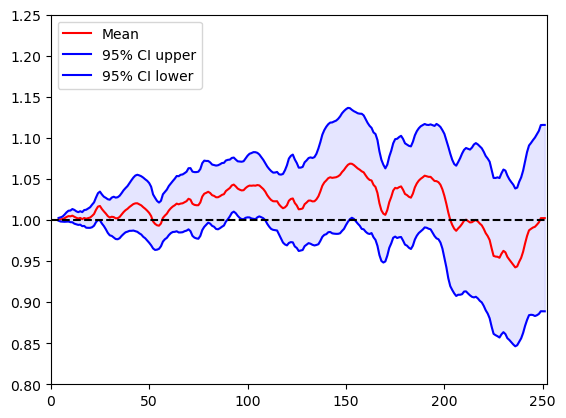

Sharpe_featuresFalse_window63_rolling5_seeds5_deltaTrue_indicator1

Annual return         -0.028866
Cumulative returns    -0.028866
Annual volatility      0.125691
Sharpe ratio          -0.171284
Calmar ratio          -0.211042
Stability              0.165596
Max drawdown          -0.136780
Omega ratio            0.971727
Sortino ratio         -0.234690
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.958493
Daily value at risk   -0.015921
dtype: float64
Annual return         -0.011070
Cumulative returns    -0.011070
Annual volatility      0.154017
Sharpe ratio           0.004372
Calmar ratio          -0.067235
Stability              0.128381
Max drawdown          -0.164640
Omega ratio            1.000750
Sortino ratio          0.005954
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.965445
Daily value at risk   -0.019402
dtype: float64
Annual return          0.072908
Cumulative returns     0.072908
Annual

In [39]:
window_size = 63
window = 5
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'


seeds = [0,1,2,3,4]
use_extra_features = False
delta = True
indicator_level = 1

reward_type = "Sharpe"
# reward_type = "Sortino"
# reward_type = "Profit"

if(delta == True):
    result_path = 'results/using_delta_'+str(indicator_level)
else:
    result_path = 'results/not_using_delta_'+str(indicator_level)
dfs = []
for seed in seeds:
    file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,window_size,use_extra_features, seed)
    file = pd.read_csv(file_name)
    dfs.append(file.copy())

plot_multiple_seeds(dfs,seeds,window,use_extra_features,'red','blue',reward_type,window_size)

print("{}_features{}_window{}_rolling{}_seeds{}_delta{}_indicator{}\n".format(reward_type,use_extra_features,window_size,window,len(seeds),str(delta),indicator_level))
save_path = "plots/{}_features{}_window{}_rolling{}_seeds{}_delta{}_indicator{}.png".format(reward_type,use_extra_features,window_size,window,len(seeds),str(delta),indicator_level)


avg_stats = compute_avg_stats_multiple_seeds(dfs)
print(avg_stats.round(3)[[0,3,6,8]])


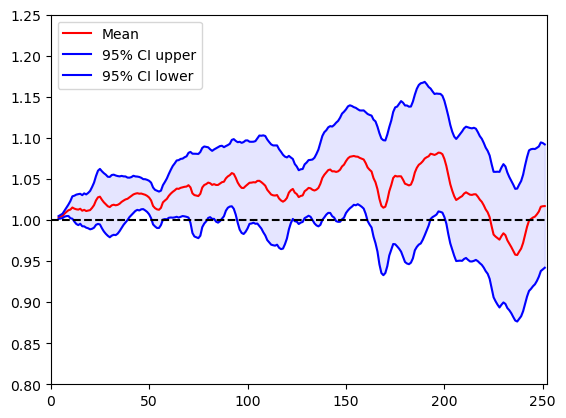

In [ ]:
save_plot_multiple_seeds(dfs,save_path,seeds,window,use_extra_features,'red','blue',reward_type,window_size)

## Save multiple plots

In [40]:
window_size = 63
window = 5
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'

stats_path = "plots/stats.txt"
stats_file = open(stats_path,"a")
seeds = [0,1,2,3,4]
use_extra_features_list = [True,False]
delta_list =[True]
indicator_level_list = [1,2]

reward_type_list = ["Sortino","Sharpe"]
# reward_type = "Sortino"
# reward_type = "Profit"
for use_extra_features in use_extra_features_list:
    for delta in delta_list:
        for indicator_level in indicator_level_list:
            for reward_type in reward_type_list: 
                if(delta == True):
                    result_path = 'results/using_delta_'+str(indicator_level)
                else:
                    result_path = 'results/not_using_delta_'+str(indicator_level)
                dfs = []
                for seed in seeds:
                    file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,window_size,use_extra_features, seed)
                    file = pd.read_csv(file_name)
                    dfs.append(file.copy())
                agent_type = "{}_features{}_window{}_rolling{}_seeds{}_delta{}_indicator{}.png".format(reward_type,use_extra_features,window_size,window,len(seeds),str(delta),indicator_level)
                save_path = "plots/{}".format(agent_type)
                save_plot_multiple_seeds(dfs,save_path,seeds,window,use_extra_features,'red','blue',reward_type,window_size)
                plt.clf()
                avg_stats = compute_avg_stats_multiple_seeds(dfs)
                rounded_stats = avg_stats.round(3)
                stats_string = "{}: {}% & {} & {} & {} \n".format(agent_type,rounded_stats[0],rounded_stats[3],rounded_stats[8],rounded_stats[6])
                stats_file.write(stats_string)
stats_file.close()



Annual return         -0.076729
Cumulative returns    -0.076729
Annual volatility      0.150264
Sharpe ratio          -0.458340
Calmar ratio          -0.426424
Stability              0.200145
Max drawdown          -0.179937
Omega ratio            0.926190
Sortino ratio         -0.615567
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.893083
Daily value at risk   -0.019205
dtype: float64
Annual return          0.060155
Cumulative returns     0.060155
Annual volatility      0.124668
Sharpe ratio           0.532577
Calmar ratio           0.495056
Stability              0.324276
Max drawdown          -0.121511
Omega ratio            1.092730
Sortino ratio          0.767027
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.040387
Daily value at risk   -0.015443
dtype: float64
Annual return         -0.104853
Cumulative returns    -0.104853
Annual volatility      0.145569
Sharpe ratio          -0.691195
Calmar rat

<Figure size 640x480 with 0 Axes>